               Gominy               Tyr               Trp
0  45.446791159494630 3.718644731004520 1.658958839543630
1  53.715968017732450 1.519253456158500 2.908843156540700
2  39.837588219318036 3.514325758417340 1.093679651809260
3  31.410666371509429 4.107808169160440 2.413379596596180
4  42.444628564694149 2.397801748277350 2.822168138776240
5  36.479939106612335 1.771191863933510 3.826667882859640
6  36.112552777464927 2.080762828858240 0.700693670286065
7  44.049333733054091 3.959066433208400 3.163624883413180
8  35.354605452902639 1.172332780942920 2.195268300827590
9  47.441840360499903 3.046103871452420 4.011520976275540
10 47.577334115601005 3.345482432441450 1.008305133569850
11 38.622682869301272 2.530966776772400 3.533569719442830
12 44.546830928591774 0.838762796009957 4.215091345623870
13 35.724430846023779 4.261242572949930 4.150725988529820
14 54.640664074782890 2.577718588091170 3.679024812424490
15 49.409746032154970 1.336313832168730 0.847237726831476
16 26.19747470

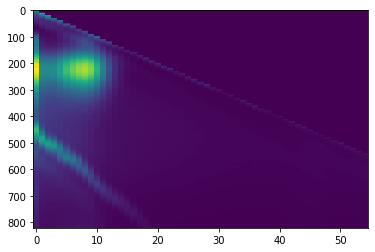

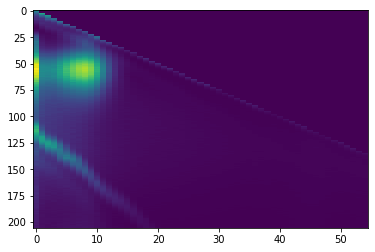

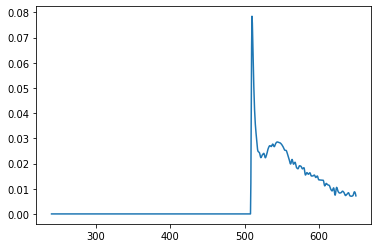

(821, 55)
[[1.06163633 0.         0.         ... 0.         0.         0.        ]
 [1.02431857 0.         0.         ... 0.         0.         0.        ]
 [0.98576825 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.13211435 0.08405734 0.07243943 ... 0.00645055 0.00743708 0.00837667]
 [0.13316927 0.08300723 0.07213626 ... 0.006427   0.00742712 0.00787191]
 [0.13434384 0.08180887 0.07159405 ... 0.00641603 0.00740772 0.00717336]]



In [36]:
from glob import glob
from gzip import open # NB: overrides standard open()
import os
import numpy as np
from scipy import interpolate
import pandas as pd
import pickle as pkl

# y = the regressors, a simple 2D array
y =pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/y.txt', sep= '\t')
y = y.replace(',','.', regex=True) #меняю ',' на '.'
y = y.astype(float) #конвертирую из string в float
y=y.assign(Gominy=y[["Pahokee peat","Nordic aquatic","Suwanee river","Elliot soil","Disser"]].sum(1)) #складываю столбцы
y=y.drop(["Pahokee peat","Nordic aquatic","Suwanee river","Elliot soil","Disser"], axis=1) #удаляю ненужные столбцы
y = y[['Gominy'] + y.columns[:-1].tolist()] #меняю порядок столбцов так, чтобы первым был Gominy
y.to_pickle('C:/Users/admin/Desktop/курсовая 2.0/y.pkl.gz') #сохраняем в pickle формате, удобном для регрессии
pd.set_option('display.float_format', '{:.15f}'.format) #контроль длинны вывода float
print(y)

# save the result
y.to_pickle('C:/Users/admin/Desktop/курсовая 2.0/y.pkl.gz')

# X = the predictors, a tensor
# dimensions: (sample, emission wavelength, excitation wavelength)

# first read the text files individually
# make sure to sort the list of files, they must correspond to rows in y
X_ = [pd.read_csv(f, sep='\t') for f in sorted(glob('C:/Users/admin/Desktop/курсовая 2.0/X — копия/??.txt'))]
# sanity check: wavelengths must be the same in all files
for x in X_[1:]:
	# errors will also happen if any of the files have different dimensions
	if not ((x.axes[0] == X_[0].axes[0]).all() and (x.axes[1] == X_[0].axes[1]).all()):
		# it doesn't quite matter what we raise here
		# the important thing is to complain loudly and crash
		raise Exception(x.axes)
pd.set_option('display.float_format', '{:.15f}'.format) #контроль длинны вывода float
k = 0
X=np.zeros([35,821,55]) #инициализирую массив нулей
tt=np.arange(240.0, 650.5, 0.5, dtype=float) #набор точек для интерполяции
fds = sorted(os.listdir('C:/Users/admin/Desktop/курсовая 2.0/X — копия/')) #формируем список файлов x для считывания в цикле
while k < 35:
    x = pd.read_csv('C:/Users/admin/Desktop/курсовая 2.0/X — копия/'+fds[k],sep='\t')
    x = x.fillna(0)
    x = x.replace(',','.', regex=True) #меняю ',' на '.'
    x = x.astype(float) #конвертирую из string в float
    colums=list(x.columns.values) #установил имена колонок
    rows=list(x.index.values)  #установил имена строчек
    ll=x.columns.values
    lrl=x.index.values
    lrl=lrl.astype(float)
    gg=0
    Xx=np.zeros([821,55]) #инициализирую массив нулей
    while gg<55:
        fgh=x.iloc[:,gg]
        a1=interpolate.PchipInterpolator(lrl,fgh, extrapolate=False)
        a2=a1(tt).astype(float)
        Xx[:,gg]+=a2
        gg+=1
    X[k,:,:]+=Xx #собираю тензор
    k = k + 1
# save the fluorescence intensity values together with wavelengths
# (like Matlab, NumPy doesn't seem to have the concept
# of "named dimensions" in >2-dimensional arrays)
pkl.dump(
	{'X': X, 'emission': X_[0].axes[0].values, 'excitation': X_[1].axes[1].values},
	open('C:/Users/admin/Desktop/курсовая 2.0/X.pkl.gz', 'wb')
)

import matplotlib.pyplot as plt
plt.imshow(Xx,aspect="auto")
plt.show();
plt.imshow(x,aspect="auto")
plt.show();
plt.plot(tt,a2)
plt.show();
print(Xx.shape)
print(Xx)
print()